# Apache Spark Introduction

* Create a Spark Session
* Write a dataframe by Delta Lake format
* Write a dataframe by Parquet format
* Manipulate data with Spark SQL (HiveQL)
* Kill a Spark Session

## 1. Introduction

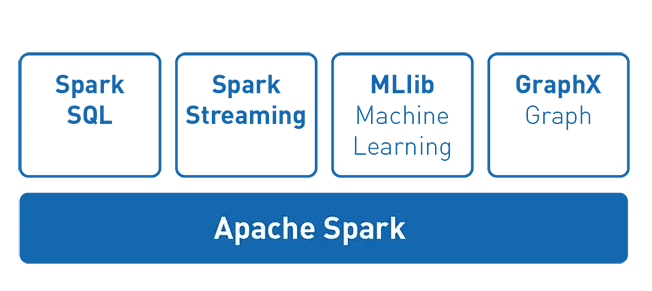

- **Spark Core:** is the general execution engine that underpins Spark. All other functions are built on top of Spark Core. It provides computing capabilities on RAM memory and also on reference data sets in external storage systems.
- **Spark SQL:** is a component on top of Spark Core, introducing a new data abstraction concept called SchemaRDD, providing support for structured and semi-structured data.
- **Spark Streaming:** takes advantage of Spark Core's memory-base scheduling capabilities to perform streaming analytics. It takes data in mini-batches and performs RDD (Resilient Distributed Data Set) transformations on those data mini-batches.
- **MLlib (Machine Learning Library):** is a distributed machine learning framework on Spark that takes advantage of the high-speed computing capabilities thanks to the distributed memory-based Spark architecture.
- **GraphX:** is a distributed graph processing framework. It provides an API to perform graph calculations that can model user-defined graphs using a pre-optimized API.

## 2. Apache Spark Vs Hadoop MapReduce

**The operating mechanism of MapReduce (MR):**
- Input data is read from HDFS (component in charge of storage in Hadoop) → processed by specified operations → output is written to HDFS → data continues to be loaded → next operation is performed → output continues to be written into HDFS. That sequence of `[read-process-write]` steps is repeated until the job is completed
- Each step needs to write output to HDFS before the next step is executed → this creates problems with storage and replication, increasing processing latency since most of it is done on Disks that are inherently I/ O is not high

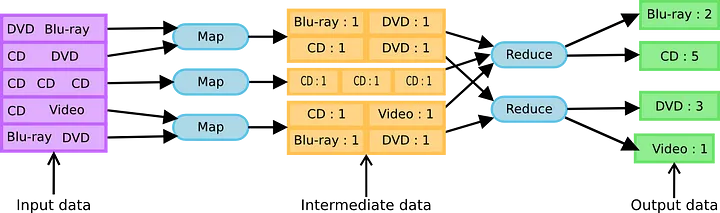

**The operating mechanism of Spark**
- Overcoming the shortcomings of Hadoop MapReduce, Spark introduces a new concept RDD — Resilient Distributed Dataset acts as a `basic data structure` in Spark
- RDD is defined as an abstraction for a set of `immutable elements` (essentially stored on read-only memory cells)
- Input data from the storage system only needs to be `loaded once`, the steps to transform and process input data are planned, optimized and performed continuously until the output is returned at the end of the job
- The entire process takes place on `RAM memory` (when RAM runs out, it will be transferred to Disk) to take advantage of high I/O performance, thereby reducing execution time `10–100 times` smaller than Hadoop. MapReduce

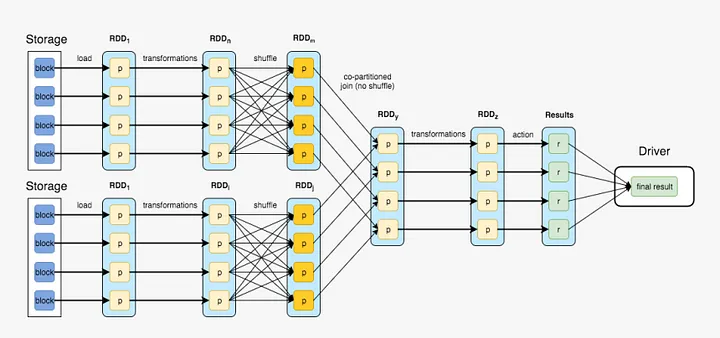

## 3. Spark Core

**SparkContext:**
- Core functionality for low-level programming and cluster interaction
- Creates RDDs
- Performs transformations and defines actions

**SparkSession:**
- Extends and includes SparkContext functionality
- Higher-level abstractions like DataFrames and Datasets
- Supports structured querying using SQL or DataFrame API
- Provides data source APIs, machine learning algorithms, and streaming capabilities

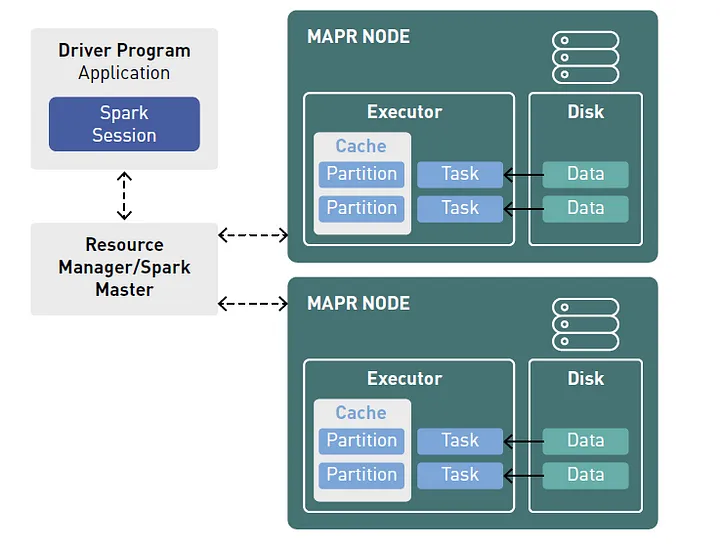

**A Spark program will include 2 main components:**

- **Driver Program:** Is a JVM Process, containing the main() function like any other JVM program, it plays the role of coordinating the code/processing logic on the Driver. Driver program contains SparkSession
- **Executors:** Are workers, responsible for performing logic calculations received from the Driver. Data to be processed can be loaded directly into the Executor's memory.


## 4. RDD - Resilient Distributed Dataset

**What is RDDs:**
- Immutable: transformations create new RDDs
- Distributed: data partitioned and processed in parallel
- Resilient: lineage tracks transformations for fault tolerance
- Lazily evaluated: execution plan optimized, transformations evaluated when necessary
- Fault-tolerant operations: map, filter, reduce, collect, count, save, etc

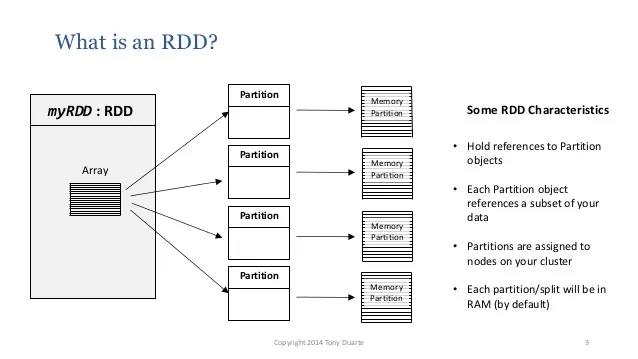

## 5. Spark DataFrame and Spark SQL

When executing, Spark SQL will still `call down` to the Core layer below, using `RDD for calculation`. Some important features of Spark SQL can be summarized as follows:
- Built on top of the Spark Core layer, inheriting all the features that RDD has.
- Work with data sets that are DataSet or DataFrame (structured, distributed data sets)
- High performance, scalability and fault tolerance
- Interoperable with other components in the overall Spark Framework (such as Streaming/ Mllib, GraphX)
- Includes 2 components: `DataSet API` and `Catalyst Optimizer`.

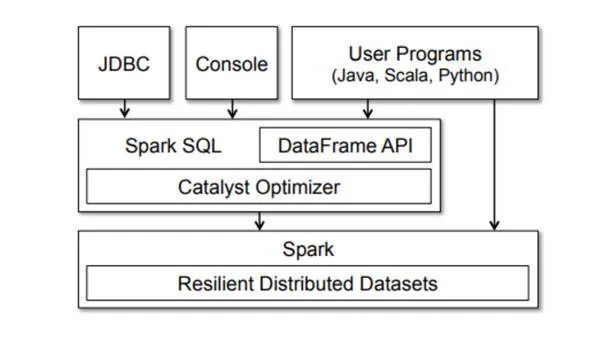!

**Advantages of DataFrames over RDDs:**
- Leverage Spark's Catalyst Optimizer: DataFrames uses Catalyst Optimizer, a powerful optimization engine that improves performance by performing advanced optimizations.
- Specific optimization techniques:
    - **Predicate Pushdown:** Data filtering (filter) is pushed to a `lower level`, helping to reduce the amount of data processed from the source.
    - **Constant Folding:** `Precalculate constant values` in expressions to reduce calculation work at runtime.
    - **Loop Unrolling:** Optimize the loop to `reduce the number of iterations` and increase execution speed.

## 6. Example for creating a SparkSession

- **Create SparkSession**

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
    .appName('Ingest checkin table into bronze') \
    .master('spark://spark-master:7077') \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083")\
    .config("spark.hadoop.fs.s3a.path.style.access", "true")\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")\
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")\
    .config('spark.sql.warehouse.dir', f's3a://lakehouse/')\
    .enableHiveSupport()\
    .getOrCreate()

In [15]:
import random

## TODO: Generate 100 sample data
names = ["Alice", "Bob", "Charlie", "David", "Emma", "Frank", "Grace", "Hannah", "Isaac", "Julia"]
data = [{"Name": random.choice(names), "Age": random.randint(20, 40)} for _ in range(100)]

df = spark.createDataFrame(data)

In [18]:
df.show(5)

+---+-----+
|Age| Name|
+---+-----+
| 32| Emma|
| 28|Isaac|
| 40|Julia|
| 24|David|
| 26|Alice|
+---+-----+
only showing top 5 rows



In [19]:
df.printSchema()

root
 |-- Age: long (nullable = true)
 |-- Name: string (nullable = true)



In [20]:
print("The number of rows", df.count())
print("The number of columns", len(df.columns))

The number of rows 100
The number of columns 2


- **Kill Spark Session**

In [31]:
spark.stop()